In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import hjson
from typing import Literal, Annotated

import pygmo
from loguru import logger
import datetime

# SolarMED modeling
from solarMED_modeling.solar_med import SolarMED
from solarMED_modeling import MedVacuumState
from solarMED_modeling.utils.matlab_environment import set_matlab_environment
from solarMED_optimization import EnvVarsSolarMED, CostVarsSolarMED

set_matlab_environment()

%load_ext autoreload
%autoreload 2

date_str: str = '20230707_20230710'
filenames_process_data = [f'{date_str}_solarMED.csv', f'{date_str}_MED.csv']

data_path: Path = Path(f'{os.getenv("HOME")}/Nextcloud/Juanmi_MED_PSA/EURECAT/data')
config_path: Path = Path(f'{os.getenv("HOME")}/development_psa/SolarMED-modeling/data')
# Create output_path to store results
output_path: Path = Path("results")
output_path_docs: Path = Path("docs/attachments")

sample_rate = '300s'
sample_rate_numeric = int(sample_rate[:-1])

idx_start = 0
model_sample_rate = sample_rate_numeric # seconds
n_of_dec_vars_updates: int = 10 # Number of decision variables updates per prediction horizon
prediction_horizon_duration = 24*3600 # seconds
Np = prediction_horizon_duration//model_sample_rate 
default_cost_w = 3 # €/m3
default_cost_e = 0.05 # €/kWh

In [2]:
# Process experimental data
from solarMED_modeling.utils import data_preprocessing, data_conditioning

data_paths = [data_path / filename_process_data for filename_process_data in filenames_process_data]

# 20230707_20230710 data does not include solar irradiation
# An alternative source from http://heliot.psa.es/meteo_psa_2022 is used for the solar irradiance
data_paths.append(data_path/"environment_data/env_20230707_20230710.csv")

# 20230707_20230710 does not include continuous seawater temperature and salinity
# An alternative source from https://doi.org/10.25423/CMCC/MEDSEA_ANALYSISFORECAST_PHY_006_013_EAS8 is used for seawater temperature and salinity
data_paths.append(data_path/"external_data/env_20220524_20240524.csv")

with open( config_path / "variables_config.hjson") as f:
    vars_config = hjson.load(f)
    
# Load data and preprocess data
df = data_preprocessing(data_paths, vars_config, sample_rate_key=sample_rate, fill_nans=True)

# Condition data
df = data_conditioning(df, sample_rate_numeric=sample_rate_numeric, vars_config=vars_config)

# 20230707_20230710 data does not include solar irradiation
# An alternative source from http://heliot.psa.es/meteo_psa_2022 is used for irradiance and ambient temperature

# 20230707_20230710 does not include continuos seawater temperature and salinity
# An alternative source from https://doi.org/10.25423/CMCC/MEDSEA_ANALYSISFORECAST_PHY_006_013_EAS8 is used for seawater temperature and salinity

df.rename(columns={
    # First rename the original columns
    "I": "I_orig", "Tamb": "Tamb_orig", 
    "Tmed_c_in": "Tmed_c_in_orig", "wmed_f": "wmed_f_orig", 
    
    # Then rename the new columns
    "GHI (W/m²)": "I", "Temperature (ºC)": "Tamb", 
    "DNI (W/m²)": "DNI", "DHI (W/m²)": "DHI",
    "so": "wmed_f", "thetao": "Tmed_c_in"
}, inplace=True)

# There should be no duplicates
for col in df.columns:
    print(col) if col in ["Tmed_c_in", "Tamb", "I", "wmed_f"] else None
    

2024-07-01 15:23:38.209 | INFO     | solarMED_modeling.utils:data_preprocessing:112 - Reading data from 20230707_20230710_solarMED.csv
2024-07-01 15:23:39.279 | DEBUG    | solarMED_modeling.utils:process_dataframe:68 - Index([], dtype='object')
2024-07-01 15:23:39.296 | INFO     | solarMED_modeling.utils:process_dataframe:75 - Number of duplicate index values in df: 0
2024-07-01 15:23:39.389 | INFO     | solarMED_modeling.utils:data_preprocessing:132 - Reading data from 20230707_20230710_MED.csv
2024-07-01 15:23:39.678 | DEBUG    | solarMED_modeling.utils:process_dataframe:68 - Index([], dtype='object')
2024-07-01 15:23:39.679 | INFO     | solarMED_modeling.utils:process_dataframe:75 - Number of duplicate index values in df: 0
2024-07-01 15:23:39.682 | DEBUG    | solarMED_modeling.utils:data_preprocessing:151 - Common columns in both dataframes: Index(['FT-AQU-100', 'SC-AQU-P102', 'TT-DES-030'], dtype='object'), dropping them from the auxiliary dataframe.
2024-07-01 15:23:39.710 | INFO

Tamb
I
wmed_f
Tmed_c_in


In [4]:
init_vars = dict(Tts_h=[], Tts_c=[], Tsf_in_ant=np.array([0]), msf_ant=np.array([0]), resolution_mode="simple")
model = SolarMED(**init_vars)


class my_solarmed_minlp:
    def __init__(self, n_of_dec_vars_updates: int):
        self.n_dec_var_updates = n_of_dec_vars_updates
        
    def get_bounds(self) -> tuple[list[float], list[float]]:
        """Return the bounds of the decision variables."""

        lb = []; ub = []

        # Continuous variables
        ## mts_src
        bounds = [float(model.lims_mts_src[0])] * self.n_dec_var_updates
        lb.extend(bounds)
        
        bounds = [float(model.lims_mts_src[1])] * self.n_dec_var_updates
        ub.extend(bounds)

        ## Tsf_out
        bounds = [float(model.lims_Tsf_out[0])] * self.n_dec_var_updates
        lb.extend(bounds)
        bounds = [float(model.lims_Tsf_out[1])] * self.n_dec_var_updates
        ub.extend(bounds)

        ## mmed_s
        bounds = [float(model.lims_mmed_s[0])] * self.n_dec_var_updates
        lb.extend(bounds)
        bounds = [float(model.lims_mmed_s[1])] * self.n_dec_var_updates
        ub.extend(bounds)

        ## mmed_f
        bounds = [float(model.lims_mmed_f[0])] * self.n_dec_var_updates
        lb.extend(bounds)
        bounds = [float(model.lims_mmed_f[1])] * self.n_dec_var_updates
        ub.extend(bounds)

        ## Tmed_s_in
        bounds = [float(model.lims_Tmed_s_in[0])] * self.n_dec_var_updates
        lb.extend(bounds)
        bounds = [float(model.lims_Tmed_s_in[1])] * self.n_dec_var_updates
        ub.extend(bounds)

        ## Tmed_c_out
        lb.extend([20.0] * self.n_dec_var_updates)
        ub.extend([24.0] * self.n_dec_var_updates)
        
        # Integer variables
        ## med_vacuum_state
        lb.append(0)
        ub.append(2)
        
        ## sf_pump_state
        lb.append(0)
        ub.append(1)
        
        ## ts_pump_state
        lb.append(0)
        ub.append(1)

        return lb, ub

    def get_nic(self):
        """Return the number of inequality constraints.
        If the UDP does not implement the get_nic() method, zero inequality constraints will be assumed.
        """
        pass

    def get_nec(self):
        """Return the number of equality constraints.
        If the UDP does not implement the get_nec() method, zero equality constraints will be assumed
        """
        pass

    def get_nix(self):
        """Return the number of integer decision variables.
        - Vacuum system state (0: off, 1: low, 2: high)
        - Solar field pump state (0: off, 1: on)
        - Thermal storage pump state (0: off, 1: on)
        """
        return 3

    def fitness(self, x):
        """Return the fitness of the decision variables."""
        pass

2024-07-01 15:24:43.308 | INFO     | solarMED_modeling.solar_med:init_matlab_engine:717 - MATLAB engine initialized
2024-07-01 15:24:43.309 | INFO     | solarMED_modeling.solar_med:model_post_init:538 - 
        SolarMED model initialized with: 
            - Evaluating models: True
            - Evaluating finite state machines: False
            - Resolution mode: simple
            - Sample time: 60 s
            - MED actuators: ['med_brine_pump', 'med_feed_pump', 'med_distillate_pump', 'med_cooling_pump', 'med_heatsource_pump']
            - Solar field actuators: ['sf_pump']
            - Thermal storage actuators: ['ts_src_pump']
        


In [4]:
# Evaluate "optimal" operation for the episode

# Initialize model
# model = SolarMED(
#     use_models=True,
#     use_finite_state_machine=True,
#     resolution_mode="simple",
#     sample_time=model_sample_rate,
#     
#     # If a slow sample time is used, the solar field internal PID needs to be detuned
#     # Ki_sf=-0.0001,
#     # Kp_sf=-0.005,
#     
#     # Initial states
#     ## Thermal storage
#     Tts_h=[df['Tts_h_t'].iloc[idx_start], 
#            df['Tts_h_m'].iloc[idx_start], 
#            df['Tts_h_b'].iloc[idx_start]], 
#     Tts_c=[df['Tts_c_t'].iloc[idx_start], 
#            df['Tts_c_m'].iloc[idx_start], 
#            df['Tts_c_b'].iloc[idx_start]],
#     ## Solar field
#     Tsf_in_ant=np.full((model_sample_rate*10, 1), df['Tsf_in'].iloc[idx_start]),
#     msf_ant=np.full((model_sample_rate*10, 1), df['qsf'].iloc[idx_start]),
# )

# Simulation loop
# for step_idx in range(idx_start, len(df)-(idx_start+Np)):
step_idx = idx_start

# Predict environment variables
# TODO - For now just use the available data

# Generate decision variables update samples
# TODO - For now just distribute them uniformly
# With numpy it's simpler to work with row vectors than column vectors
samples_opt: np.ndarray[bool] = np.full((Np, 1), False, dtype=bool)
samples_opt[::int(np.ceil(Np/n_of_dec_vars_updates, ))] = True

assert np.sum(samples_opt) == n_of_dec_vars_updates, f"Number of decision variables updates ({np.sum(samples_opt)}) does not match the expected number of updates ({n_of_dec_vars_updates})"

# Setup additional required variables
env_vars: EnvVarsSolarMED = EnvVarsSolarMED(
    Tmed_c_in=df["Tmed_c_in"].iloc[step_idx:step_idx+Np].values,
    Tamb=df["Tamb"].iloc[step_idx:step_idx+Np].values,
    I=df["I"].iloc[step_idx:step_idx+Np].values,
    wmed_f=df["wmed_f"].iloc[step_idx:step_idx+Np].values if "wmed_f" in df.columns else None
)

cost_vars: CostVarsSolarMED = CostVarsSolarMED(
    costs_w=df["costs_w"].iloc[step_idx:step_idx+Np].values if "costs_w" in df.columns else np.full((1, Np), default_cost_w),
    costs_e=df["costs_e"].iloc[step_idx:step_idx+Np].values if "costs_e" in df.columns else np.full((1, Np), default_cost_e)
)


2024-06-21 16:19:23.256 | INFO     | solarMED_modeling.solar_med:init_matlab_engine:717 - MATLAB engine initialized
2024-06-21 16:19:23.270 | INFO     | solarMED_modeling.solar_med:model_post_init:538 - 
        SolarMED model initialized with: 
            - Evaluating models: True
            - Evaluating finite state machines: True
            - Resolution mode: simple
            - Sample time: 300.0 s
            - MED actuators: ['med_brine_pump', 'med_feed_pump', 'med_distillate_pump', 'med_cooling_pump', 'med_heatsource_pump']
            - Solar field actuators: ['sf_pump']
            - Thermal storage actuators: ['ts_src_pump']
        


In [ ]:
import pygmo as pg

pygmo.constant_arguments

Problem name: <class '__main__.my_minlp'>
	C++ class name: pybind11::object

	Global dimension:			6
	Integer dimension:			2
	Fitness dimension:			7
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	6
	Tolerances on constraints: [0, 0, 0, 0, 0, ... ]
	Lower bounds: [-5, -5, -5, -5, -5, ... ]
	Upper bounds: [5, 5, 5, 5, 5, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Problem name: <class '__main__.my_minlp'>
	C++ class name: pybind11::object

	Global dimension:			6
	Integer dimension:			2
	Fitness dimension:			7
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	6
	Tolerances on constraints: [0, 0, 0, 0, 0, ... ]
	Lower bounds: [-5, -5, -5, -5, -5, ... ]
	Upper bounds: [5, 5, 5, 5, 5, ... ]
	Has batch fitness evaluation: f

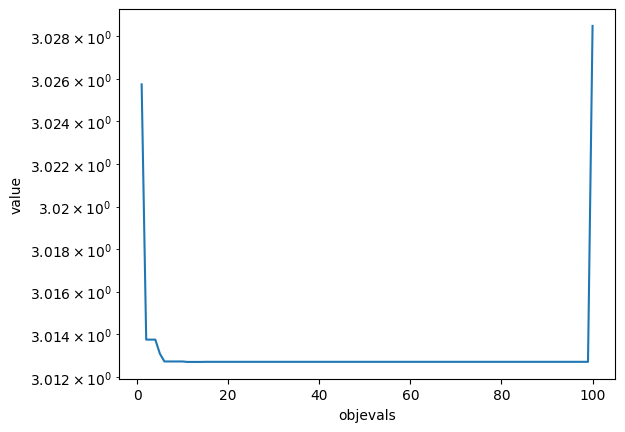

Problem name: <class '__main__.my_minlp'>
	C++ class name: pybind11::object

	Global dimension:			6
	Integer dimension:			2
	Fitness dimension:			7
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	6
	Tolerances on constraints: [0, 0, 0, 0, 0, ... ]
	Lower bounds: [-5, -5, -5, -5, -5, ... ]
	Upper bounds: [5, 5, 5, 5, 5, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 20

	Thread safety: none

Population size: 20

List of individuals: 
#0:
	ID:			15081243373645542631
	Decision vector:	[0.0707058, -1.59676, 3.51262, 2.06937, 5, ... ]
	Fitness vector:		[3.02574, 0.131413, -1.75934, -1.82505, -1.89076, ... ]
#1:
	ID:			5365422283576396189
	Decision vector:	[-3.61456, -1.3354, -0.283979, 4.95078, -3, ... ]
	Fitness vector:		[3.13126, -33.3592, -511.839, -495.16, -478.48, ... ]
#2:
	ID:			9496930608

In [55]:
import math
import pygmo as pg
from pprint import pprint
from matplotlib import pyplot as plt 


class my_minlp:

    def fitness(self, x):
        obj = 0

        for i in range(3):
            obj += (x[2*i-2]-3)**2 / 1000. - (x[2*i-2]-x[2*i-1]) + math.exp(20.*(x[2*i - 2]-x[2*i-1]))

        ce1 = 4*(x[0]-x[1])**2+x[1]-x[2]**2+x[2]-x[3]**2
        ce2 = 8*x[1]*(x[1]**2-x[0])-2*(1-x[1])+4*(x[1]-x[2])**2+x[0]**2+x[2]-x[3]**2+x[3]-x[4]**2
        ce3 = 8*x[2]*(x[2]**2-x[1])-2*(1-x[2])+4*(x[2]-x[3])**2+x[1]**2-x[0]+x[3]-x[4]**2+x[0]**2+x[4]-x[5]**2
        ce4 = 8*x[3]*(x[3]**2-x[2])-2*(1-x[3])+4*(x[3]-x[4])**2+x[2]**2-x[1]+x[4]-x[5]**2+x[1]**2+x[5]-x[0]
        ci1 = 8*x[4]*(x[4]**2-x[3])-2*(1-x[4])+4*(x[4]-x[5])**2+x[3]**2-x[2]+x[5]+x[2]**2-x[1]
        ci2 = -(8*x[5] * (x[5]**2-x[4])-2*(1-x[5]) +x[4]**2-x[3]+x[3]**2 - x[4])

        return [obj, ce1,ce2,ce3,ce4,ci1,ci2]

    def get_bounds(self):
        return ([-5]*6,[5]*6)

    def get_nic(self):
        return 6

    def get_nix(self):
        return 2
    

prob = pg.problem(my_minlp())
pop = pg.population(prob, size=20)
algo = pg.algorithm(pg.gaco(gen=100, ker=20))
algo.set_verbosity(1)
# 
# archi = pg.archipelago(n=5, algo=algo, prob=prob, pop_size=10)
# 
# # pop = archi.evolve()
# print(archi)
# 
# pprint( archi.get_champions_f() )
# print("\n")
# pprint( archi.get_champions_x() )
print(prob)
print(pop)
print(algo)

algo.evolve(pop)


# Plot
log = algo.extract(pg.gaco).get_log()
plt.semilogy([line[0] for line in log], [line[2] for line in log], label = "obj") 
# plt.semilogy([line[0] for line in log], [line[3] for line in log], label = "con") 
plt.xlabel("objevals") 
plt.ylabel("value") 

plt.show() 

print(pop)


In [52]:
log

[(1, 0, 3.013132242282544, 20, 0.0, 22.340924040876757, 876.6302895281787),
 (2, 20, 3.013132242282544, 20, 0.0, 20.314856808954566, 122.72858970102851),
 (3, 40, 3.013132242282544, 20, 0.0, 19.855734628695892, 40.61419069049462),
 (4, 60, 3.012964651198633, 20, 0.0, 17.192992890641406, 5.805220351023685),
 (5, 80, 3.012934147540994, 20, 0.0, 16.122963993144566, 0.36812696970875214),
 (6, 100, 3.012817375592798, 20, 0.0, 8.045686132099, 0.3361904523923891),
 (7, 120, 3.012817375592798, 20, 0.0, 13.8183210566419, 0.29454518960306375),
 (8, 140, 3.012744932338524, 20, 0.0, 5.289871011971574, 0.2482202861013434),
 (9, 160, 3.012744932338524, 20, 0.0, 5.903023964019378, 0.13052820188076897),
 (10,
  180,
  3.012737882266419,
  20,
  0.0,
  10.944692255024275,
  0.08645411483867393),
 (11,
  200,
  3.012737882266419,
  20,
  0.0,
  11.494089026274455,
  0.05482095613244509),
 (12, 220, 3.012737882266419, 20, 0.0, 9.57526038194203, 0.05207835262431404),
 (13, 240, 3.012737882266419, 20, 0.0,

In [17]:
archi.evolve() 
print(archi)

Number of islands: 5
Topology: Unconnected
Migration type: point-to-point
Migrant handling policy: preserve
Status: busy

Islands summaries:

	#  Type                    Algo                           Prob                         Size  Status  
	-----------------------------------------------------------------------------------------------------
	0  Multiprocessing island  GACO: Ant Colony Optimization  <class '__main__.my_minlp'>  10    busy    
	1  Multiprocessing island  GACO: Ant Colony Optimization  <class '__main__.my_minlp'>  10    busy    
	2  Multiprocessing island  GACO: Ant Colony Optimization  <class '__main__.my_minlp'>  10    busy    
	3  Multiprocessing island  GACO: Ant Colony Optimization  <class '__main__.my_minlp'>  10    busy    
	4  Multiprocessing island  GACO: Ant Colony Optimization  <class '__main__.my_minlp'>  10    busy    



In [19]:
archi.wait()
print(archi)
pprint( archi.get_champions_f() )
print("\n")
pprint( archi.get_champions_x() )

Number of islands: 5
Topology: Unconnected
Migration type: point-to-point
Migrant handling policy: preserve
Status: idle - **error occurred**

Islands summaries:

	#  Type                    Algo                           Prob                         Size  Status                     
	------------------------------------------------------------------------------------------------------------------------
	0  Multiprocessing island  GACO: Ant Colony Optimization  <class '__main__.my_minlp'>  10    idle - **error occurred**  
	1  Multiprocessing island  GACO: Ant Colony Optimization  <class '__main__.my_minlp'>  10    idle - **error occurred**  
	2  Multiprocessing island  GACO: Ant Colony Optimization  <class '__main__.my_minlp'>  10    idle - **error occurred**  
	3  Multiprocessing island  GACO: Ant Colony Optimization  <class '__main__.my_minlp'>  10    idle - **error occurred**  
	4  Multiprocessing island  GACO: Ant Colony Optimization  <class '__main__.my_minlp'>  10    idle - **er

In [44]:
import pygmo as pg

prob = pg.problem(pg.rosenbrock(dim = 2))

print(prob)

pop = pg.population(prob, size=50, seed=23)

print(pop)

algo = pg.algorithm(pg.gaco(gen=100, ker=50, q=1.0, oracle=1e9))

print(algo)

algo.set_verbosity(1)

pop = algo.evolve(pop) 

uda = algo.extract(pg.gaco)

print(uda.get_log()) 

print(pop.champion_f)
print(pop.champion_x)

Problem name: Multidimensional Rosenbrock Function
	C++ class name: pagmo::rosenbrock

	Global dimension:			2
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-5, -5]
	Upper bounds: [10, 10]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 2
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: constant

Problem name: Multidimensional Rosenbrock Function
	C++ class name: pagmo::rosenbrock

	Global dimension:			2
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-5, -5]
	Upper bounds: [10, 10]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 2